In [1]:
import tensorflow as tf
import numpy as np
from util import *
import os
import matplotlib.pyplot as plt
from tensorflow.python.ops import control_flow_ops
from losses import *
from flags_and_variables import *
from encode_boxes import *
from fcos import *
from tensorpack.tfutils.optimizer import AccumGradOptimizer
import random

In [2]:
pyramid_dict = get_fpn_output(inputs,is_training=False,is_trainable=True,backbone=FLAGS.backbone)
centerness_output,classes_output,boxes_output = get_network_output(feature_layer_list,pyramid_dict,feature_size,is_training=True)
centerness_output = tf.concat(centerness_output,axis=1)
classes_output = tf.concat(classes_output,axis=1)
boxes_output = tf.concat(boxes_output,axis=1)

In [3]:
#training part
centerness_output_test = centerness_output
classes_output_test = classes_output
boxes_output_test = boxes_output

In [4]:
###testing part
centerness_pred = tf.sigmoid(centerness_output)
classes_pred = tf.sigmoid(classes_output)
localization_pred = boxes_output
_scores,_classes,_boxes = predict_outputs(centerness_pred,classes_pred,localization_pred,feature_size)

In [5]:
#focal loss
focal_losses = focal_loss(classes,classes_output_test,state)
IOU_losses = iou_loss(boxes, boxes_output_test,state,centerness)
centerness_losses = centerness_loss(centerness, centerness_output_test,state)
regular_loss = tf.losses.get_regularization_loss()/tf.reduce_sum(state)
total_losses = focal_losses+IOU_losses+centerness_losses+regular_loss

In [6]:
tf.summary.scalar('scala/total_losses',total_losses)
tf.summary.scalar('scala/focal_losses',focal_losses)
tf.summary.scalar('scala/IOU_losses',IOU_losses)
tf.summary.scalar('scala/centerness_losses',centerness_losses)
tf.summary.scalar('scala/reg_loss',regular_loss)
ckpt = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
if ckpt:
    start_step = int(ckpt.split('-')[-1])
else:
    start_step = 0  
    
with tf.variable_scope("optimizer") as scope:
    global_step = tf.get_variable("step", [], initializer=tf.constant_initializer(start_step), trainable=False)
#     rate = tf.train.exponential_decay(FLAGS.learning_rate, global_step, decay_steps=20000, decay_rate=0.1, staircase=True)
    rate = FLAGS.learning_rate
    update_opts = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies([tf.group(update_opts)]):
        adam_opt = tf.train.AdamOptimizer(rate)
#         momentum_opt = tf.train.MomentumOptimizer(rate,momentum=0.9)
#         SGD_opt = tf.train.GradientDescentOptimizer(learning_rate=rate)
        train_opt = AccumGradOptimizer(adam_opt, niter=iter_size).minimize(total_losses,global_step=global_step)
tf.summary.scalar('scala/learning_rate',rate)
merged_summary_op = tf.summary.merge_all()

[1225 15:06:47 @gradproc.py:79] WRN No gradient w.r.t 3 trainable variables: resnet_v2_50/postnorm/gamma, resnet_v2_50/postnorm/beta, resnet_v2_50/logits/biases


In [7]:
annotation_2012_train = get_path_and_annotation(FLAGS.train_2012_dir)
annotation_2007_train = get_path_and_annotation(FLAGS.train_2007_dir)
annotation_train = annotation_2012_train +annotation_2007_train

annotation_2012_test = get_path_and_annotation(FLAGS.test_2012_dir)
annotation_2007_test = get_path_and_annotation(FLAGS.test_2007_dir)
annotation_test = annotation_2012_test +annotation_2007_test

train_iter = read_data(annotation_train,FLAGS.batch_size,input_shape=(FLAGS.image_height,FLAGS.image_width),is_random=True,is_crop=False)
test_iter = read_data(annotation_test,1,input_shape=(FLAGS.image_height,FLAGS.image_width),is_random=False,is_crop=False)

INFO:tensorflow:Restoring parameters from /media/xinje/New Volume/fcos/resnet_v2_50_freeze_bn/FCOS-resnet_v2_50-350
Restore from the checkpoint /media/xinje/New Volume/fcos/resnet_v2_50_freeze_bn/FCOS-resnet_v2_50-350
Batch: 351   Current total loss: 1.457983 focal_loss: 0.31205803 IOU_loss: 0.34746122 centerness_loss: 0.5996948
Batch: 352   Current total loss: 1.3797663 focal_loss: 0.21123673 IOU_loss: 0.47414392 centerness_loss: 0.6061237
Batch: 353   Current total loss: 1.5537958 focal_loss: 0.34817362 IOU_loss: 0.5130168 centerness_loss: 0.62519217
Batch: 354   Current total loss: 1.4618759 focal_loss: 0.3260879 IOU_loss: 0.3660784 centerness_loss: 0.59507746
Batch: 355   Current total loss: 1.3061113 focal_loss: 0.21996218 IOU_loss: 0.26997682 centerness_loss: 0.58332986
Batch: 356   Current total loss: 1.3991365 focal_loss: 0.25465322 IOU_loss: 0.42615297 centerness_loss: 0.61125696
Batch: 357   Current total loss: 1.4980494 focal_loss: 0.32964417 IOU_loss: 0.3939776 centerness_l

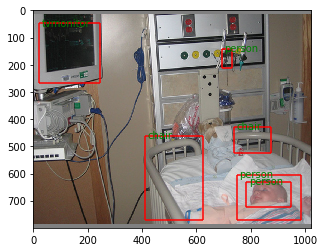

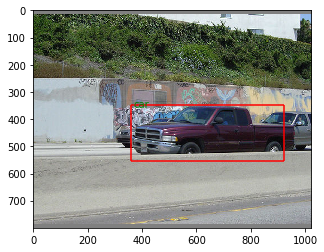

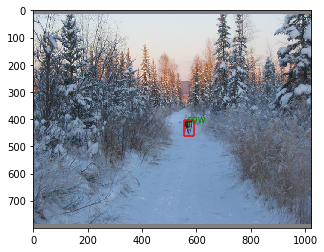

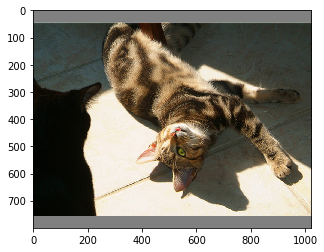

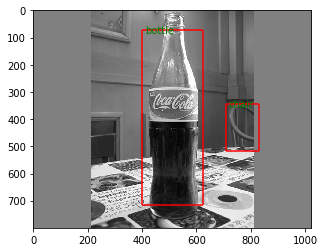

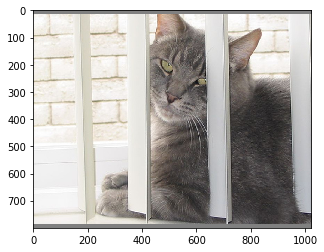

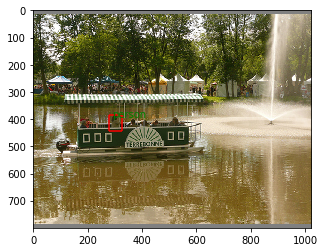

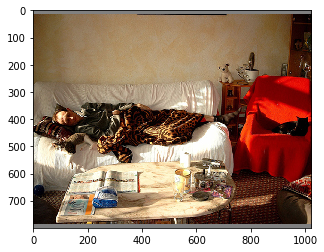

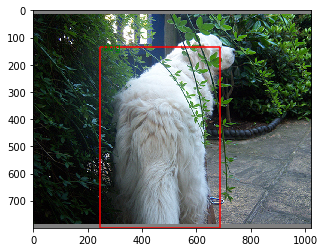

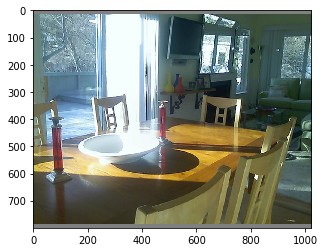

Model saved !!!
Batch: 401   Current total loss: 1.3752291 focal_loss: 0.21779132 IOU_loss: 0.4724872 centerness_loss: 0.60918677
Batch: 402   Current total loss: 1.4145228 focal_loss: 0.20962046 IOU_loss: 0.51649255 centerness_loss: 0.6162254
Batch: 403   Current total loss: 1.3779907 focal_loss: 0.22009128 IOU_loss: 0.489523 centerness_loss: 0.6149611
Batch: 404   Current total loss: 1.5663435 focal_loss: 0.33015126 IOU_loss: 0.41842073 centerness_loss: 0.57810146
Batch: 405   Current total loss: 1.5282981 focal_loss: 0.29212156 IOU_loss: 0.5096411 centerness_loss: 0.602861
Batch: 406   Current total loss: 1.3465313 focal_loss: 0.21895352 IOU_loss: 0.3925759 centerness_loss: 0.6047377
Batch: 407   Current total loss: 1.4953508 focal_loss: 0.2651908 IOU_loss: 0.5536291 centerness_loss: 0.61275834
Batch: 408   Current total loss: 1.4466652 focal_loss: 0.2380698 IOU_loss: 0.45344302 centerness_loss: 0.60935014
Batch: 409   Current total loss: 1.4012226 focal_loss: 0.26037756 IOU_loss: 0

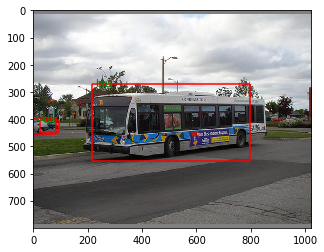

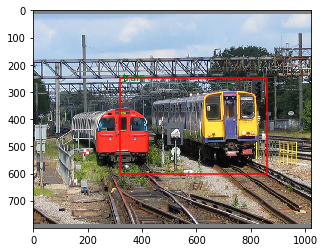

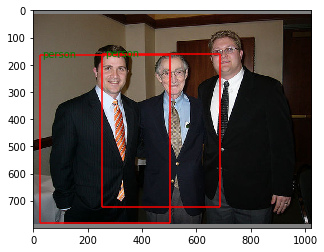

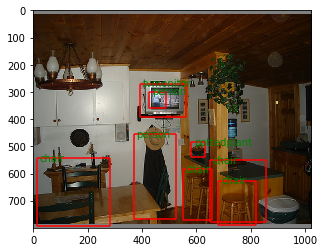

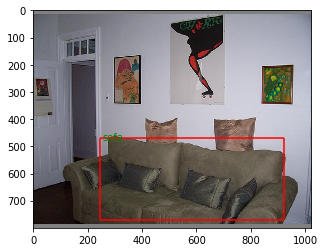

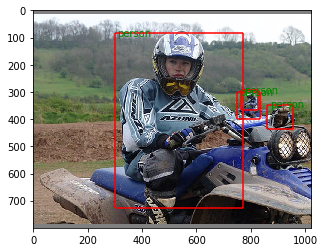

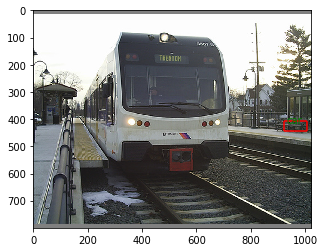

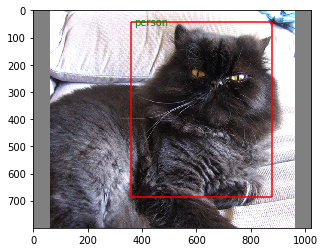

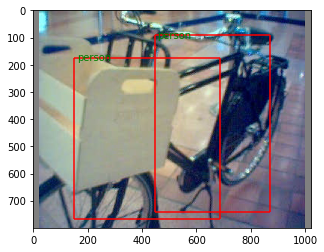

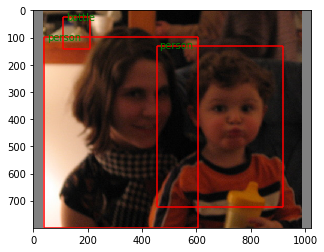

Model saved !!!
Batch: 451   Current total loss: 1.2748264 focal_loss: 0.1923455 IOU_loss: 0.35256308 centerness_loss: 0.57455194
Batch: 452   Current total loss: 1.513876 focal_loss: 0.28028616 IOU_loss: 0.5170624 centerness_loss: 0.60641855
Batch: 453   Current total loss: 1.4966446 focal_loss: 0.2910417 IOU_loss: 0.52703327 centerness_loss: 0.61250454
Batch: 454   Current total loss: 1.4591159 focal_loss: 0.2191796 IOU_loss: 0.4391106 centerness_loss: 0.6241215
Batch: 455   Current total loss: 1.3436016 focal_loss: 0.2028047 IOU_loss: 0.37769452 centerness_loss: 0.60086316
Batch: 456   Current total loss: 1.3454511 focal_loss: 0.25090823 IOU_loss: 0.38001564 centerness_loss: 0.5908646
Batch: 457   Current total loss: 1.4943833 focal_loss: 0.20469706 IOU_loss: 0.48074642 centerness_loss: 0.62787366
Batch: 458   Current total loss: 1.3512702 focal_loss: 0.23877822 IOU_loss: 0.42338 centerness_loss: 0.60662425
Batch: 459   Current total loss: 1.3936496 focal_loss: 0.25689733 IOU_loss: 

In [ ]:
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter(FLAGS.log_dir,sess.graph)
#     var_list = [var for var in tf.global_variables() if ('optimizer') not in var.name]
    var_list_final = tf.global_variables()
    saver_final = tf.train.Saver(var_list=var_list_final,max_to_keep=5)
    
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
    if ckpt:
        saver_final.restore(sess,ckpt)
        print('Restore from the checkpoint {0}'.format(ckpt)) 
        ####
#         exclude = ["optimizer/resnet_v2_50/"]
#         variables_to_restore = tf.contrib.slim.get_variables_to_restore(exclude=exclude)
#         saver = tf.train.Saver(var_list=variables_to_restore,max_to_keep=5)
#         saver.restore(sess,ckpt)

    else:
        print('Train ssd from start')
        if(FLAGS.backbone == 'resnet_v2_50'):
            ckpt = './resnet_v2_50_2017_04_14/resnet_v2_50.ckpt'
            exclude = ['resnet_v2_50' + '/logits', 'global_step','output','output2',"optimizer",'postnorm']
        if(FLAGS.backbone == 'vgg_16'):
            ckpt = './vgg16/vgg_16.ckpt'
            exclude = ['vgg_16' + '/logits', 'global_step','output','output2',"optimizer",'postnorm']
        variables_to_restore = tf.contrib.slim.get_variables_to_restore(exclude=exclude)
        saver = tf.train.Saver(var_list=variables_to_restore,max_to_keep=5)
        saver.restore(sess,ckpt)
        
    for iteration in range(start_step+1,10000000):
        #shuffle the whole dataset every epoch
        if(iteration%(len(annotation_train)//FLAGS.batch_size)==0):
            random.shuffle(annotation_train)
            train_iter = read_data(annotation_train,FLAGS.batch_size,input_shape=(FLAGS.image_height,FLAGS.image_width),is_random=True,is_crop=False)
        image_batch,annotation_batch,cls_batch = next(train_iter)
        #one hot for cls_batch(change class from[1,20] to [0,21])
        eye = np.eye(FLAGS.num_class)
        eye = np.concatenate([eye,np.expand_dims(np.zeros_like(eye[0]),axis=0)])
        cls_batch = eye[(cls_batch-1).astype(np.int32)].astype(np.float32)
        
        matched_true_boxes,matched_true_classes,matched_true_centerness = encode_boxes(annotation_batch,cls_batch,feature_size,stride)
        feature_state = np.squeeze(matched_true_centerness!=0,axis=-1)
        feed_dict={inputs:image_batch,boxes:matched_true_boxes,classes:matched_true_classes,centerness:matched_true_centerness,state:feature_state}
        [_,train_summary,temp_loss,temp_focal_loss,temp_iou_loss,temp_centerness_loss,temp_centerness_output,temp_classes_output,temp_boxes_output] = sess.run([train_opt,merged_summary_op,total_losses,focal_losses,IOU_losses,centerness_losses,centerness_output_test,classes_output_test,boxes_output_test],feed_dict=feed_dict)
        
        real_step = (iteration-start_step)//iter_size+start_step
        if((iteration-start_step)%iter_size==0):
            print('Batch: '+str(real_step)+'   Current total loss: '+str(temp_loss)+' focal_loss: '+str(temp_focal_loss)+' IOU_loss: '+str(temp_iou_loss)+' centerness_loss: '+str(temp_centerness_loss))
            train_writer.add_summary(train_summary, real_step)
        #save checkpoint and inference one image    
        if((iteration-start_step)%(iter_size*50)==0 and iteration!=0):
            for inference_iter in range(10):
                image_batch,annotation_batch,cls_batch = next(test_iter)
                [temp_scores_pred_list,temp_classes_pred_list,temp_localization_pred_list] = sess.run([_scores,_classes,_boxes],feed_dict={inputs:image_batch})
                ymin,xmin,ymax,xmax=np.split(temp_localization_pred_list,axis=1,indices_or_sections =4)
                ymax[ymax>FLAGS.image_height]=FLAGS.image_height
                xmax[xmax>FLAGS.image_width]=FLAGS.image_width
                ymin[ymin<0]=0
                xmin[xmin<0]=0
                plt.hlines(ymin,xmin,xmax,'r')
                plt.hlines(ymax,xmin,xmax,'r')
                plt.vlines(xmin,ymin,ymax,'r')
                plt.vlines(xmax,ymin,ymax,'r')
                for j in range(temp_classes_pred_list.shape[0]):
                    position = (ymin[j],xmin[j])
                    plt.text(position[1]+10,position[0]+10,corresponding_dict[temp_classes_pred_list[j]],color='g',size = 10)
                plt.imshow(image_batch[0])
                plt.show()
#         save model for training
            saver_final.save(sess,os.path.join(FLAGS.checkpoint_dir,'FCOS-'+FLAGS.backbone),global_step=real_step) 
            #########################save model for inference#############################################
#             constant_graph = convert_variables_to_constants(sess, sess.graph_def, ['boxes','scores','classes'])
#             with tf.gfile.FastGFile('./model.pb', mode='wb') as f:
#                 f.write(constant_graph.SerializeToString())
            #####################################################################
            print('Model saved !!!')         

In [ ]:

# learning_rate = 1e-2
# Si = tf.Variable(tf.constant(1.0,shape=[5,1],dtype=tf.float32), trainable=True)

In [ ]:
# matched_true_boxes,matched_true_classes,matched_true_centerness = encode_boxes(annotation_batch,cls_batch,feature_size,stride)

In [ ]:
def focal_loss(y_true, y_pred,anchor_state):
    """
    Compute the focal loss given the target tensor and the predicted tensor.
    As defined in https://arxiv.org/abs/1708.02002
    Args
        y_true: Tensor of target data from the generator with shape (B, N, num_classes).
        y_pred: Tensor of predicted data from the network with shape (B, N, num_classes).
    Returns
        The focal loss of y_pred w.r.t. y_true.
    """
    with tf.variable_scope("loss/focal") as scope:
        alpha=0.25
        gamma=2.0
        # compute the focal loss
        location_state = anchor_state
        labels = y_true
        # alpha 参与用于调节正负样本的平衡问题
        alpha_factor = tf.ones_like(labels) * alpha
        alpha_factor = tf.where(tf.equal(labels, 1), alpha_factor, 1 - alpha_factor)
        # focal_weight 用来使置信度较高容易的样本的 loss 比原来小, 而置信度低的难度大的 loss 变化不大
        # (1 - 0.99) ** 2 = 1e-4, (1 - 0.9) ** 2 = 1e-2
        focal_weight = tf.where(tf.equal(labels, 1), 1 - y_pred, y_pred)
        focal_weight = alpha_factor * focal_weight ** gamma
        # binary_crossentropy 是  -log(p) y=1 -log(1-p) y=others, 那么论文中统一的用 -log(pt) 来表示
        #cls_loss = focal_weight * tf.nn.sigmoid_cross_entropy_with_logits(labels=labels,logits=y_pred)
        cls_loss = focal_weight * tf.keras.backend.binary_crossentropy(target=labels,output=y_pred)
        # compute the normalizer: the number of positive anchors
        normalizer = tf.where(tf.equal(location_state, 1))
        normalizer = tf.cast(tf.shape(normalizer)[0], tf.float32)
        normalizer = tf.maximum(1.0, normalizer)
        loss = tf.reduce_sum(cls_loss) / normalizer
    return loss

In [ ]:

def iou_loss(y_true, y_pred,location_state,centerness):
    with tf.variable_scope("loss/iou") as scope:
        # pos location
        indices = tf.where(tf.equal(location_state, 1))
    #     print(indices.shape)
        if tf.size(indices) == 0:
            return tf.constant(0.0)
        y_regr_pred = tf.gather_nd(y_pred, indices)
    #     print(y_regr_pred.shape)
        y_regr_true = tf.gather_nd(y_true, indices)
        y_centerness_true = tf.gather_nd(centerness,indices)

        # (num_pos, )
        pred_top = y_regr_pred[:, 0]
        pred_bottom = y_regr_pred[:, 1]
        pred_left = y_regr_pred[:, 2]
        pred_right = y_regr_pred[:, 3]

        # (num_pos, )
        target_top = y_regr_true[:, 0]
        target_bottom = y_regr_true[:, 1]
        target_left = y_regr_true[:, 2]
        target_right = y_regr_true[:, 3]

        target_area = (target_left + target_right) * (target_top + target_bottom)
        pred_area = (pred_left + pred_right) * (pred_top + pred_bottom)
        w_intersect = tf.minimum(pred_left, target_left) + tf.minimum(pred_right, target_right)
        h_intersect = tf.minimum(pred_bottom, target_bottom) + tf.minimum(pred_top, target_top)

        g_w_intersect = tf.maximum(pred_left, target_left) + tf.maximum(pred_right, target_right)
        g_h_intersect = tf.maximum(pred_bottom, target_bottom) + tf.maximum(pred_top, target_top)
        ac_union = g_w_intersect * g_h_intersect
        euclidean_distance = tf.pow((-target_left + target_right)/2 -(-pred_left + pred_right)/2,2) + tf.pow((-target_top + target_bottom)/2 -(-pred_top + pred_bottom)/2,2)
        area_intersect = w_intersect * h_intersect
        area_union = target_area + pred_area - area_intersect
        ious = (area_intersect) / (area_union+1e-8)
        dious = 1-ious+(euclidean_distance/tf.pow(ac_union+1e-8,2))
        # (num_pos, )
        #losses = tf.reduce_sum(losses * y_centerness_true) / (tf.reduce_sum(y_centerness_true) + 1e-6)

        losses =  tf.reduce_mean(dious)
    return losses